In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [104]:
source = pd.read_csv('datasets/housing.tgz', compression='tar')
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [105]:
source['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [106]:
order_ocean_proximity = ['ISLAND', 'NEAR BAY', 'NEAR OCEAN', '<1H OCEAN', 'INLAND']

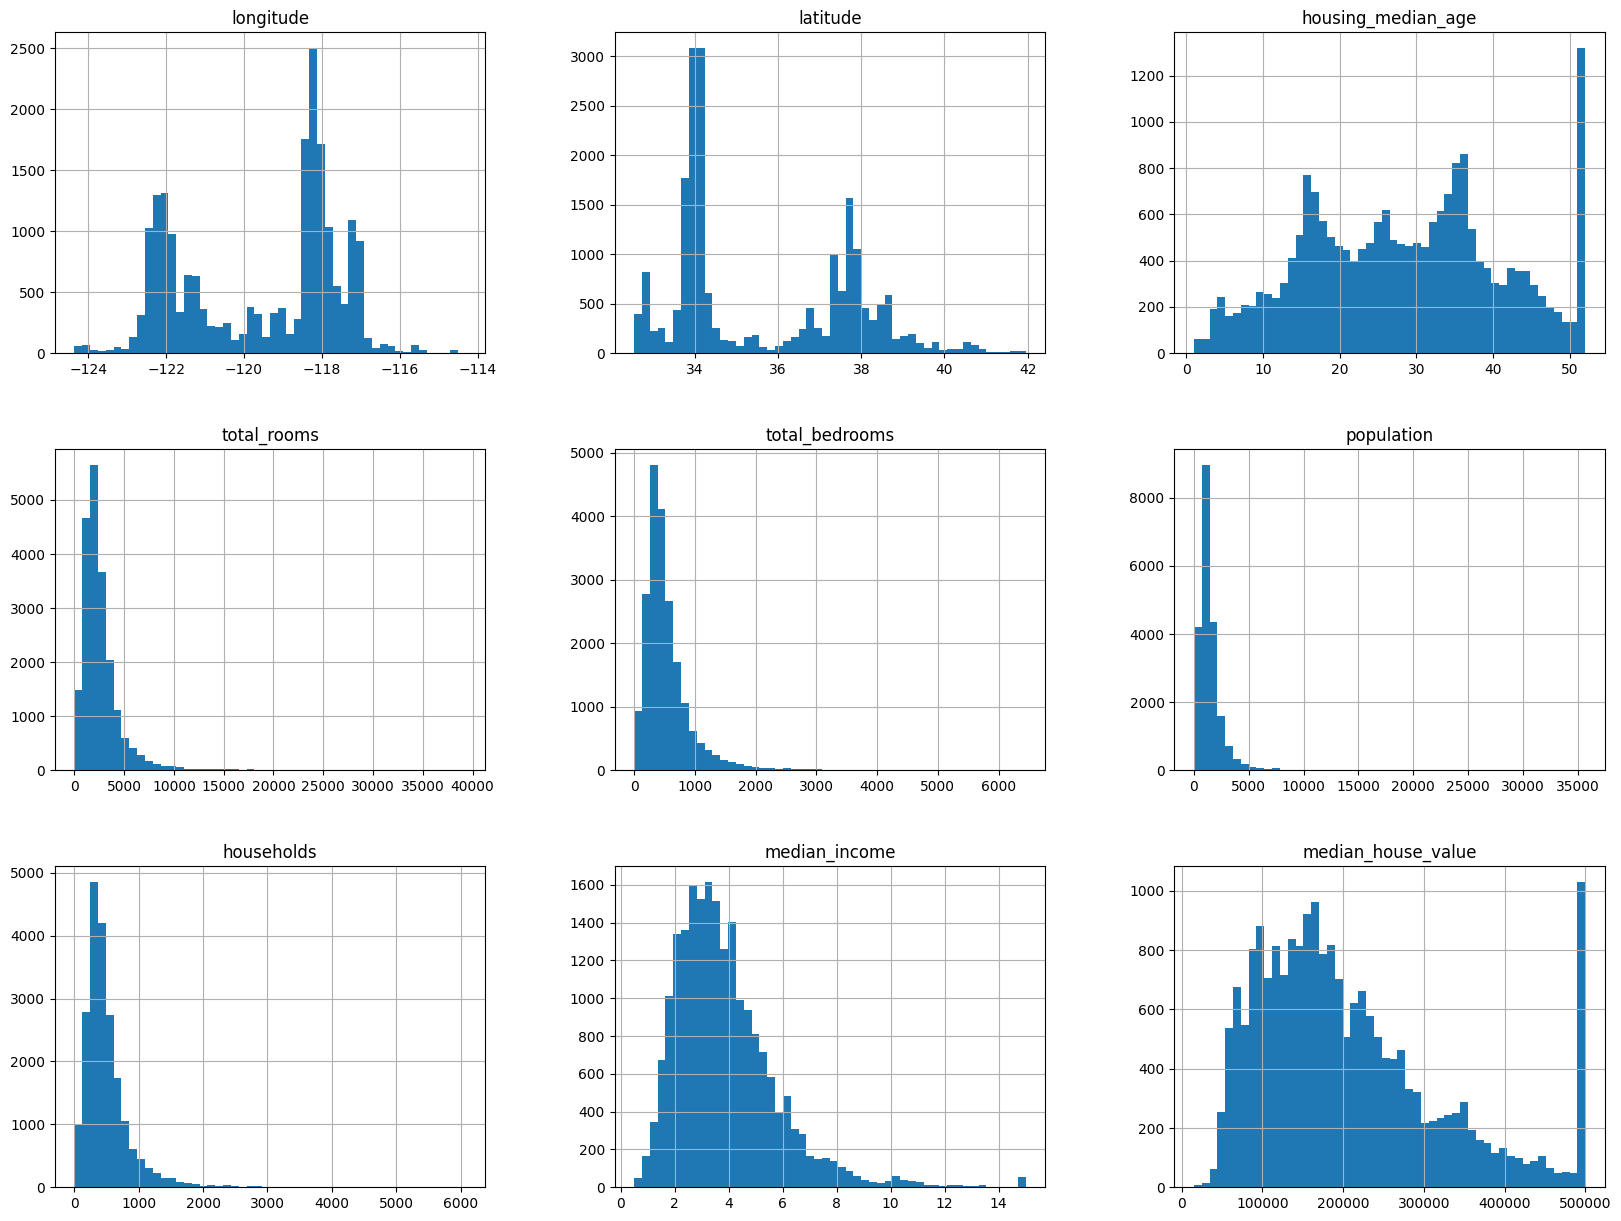

In [107]:
source.hist(bins=50, figsize=(20,15))
plt.show()

In [108]:
source.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


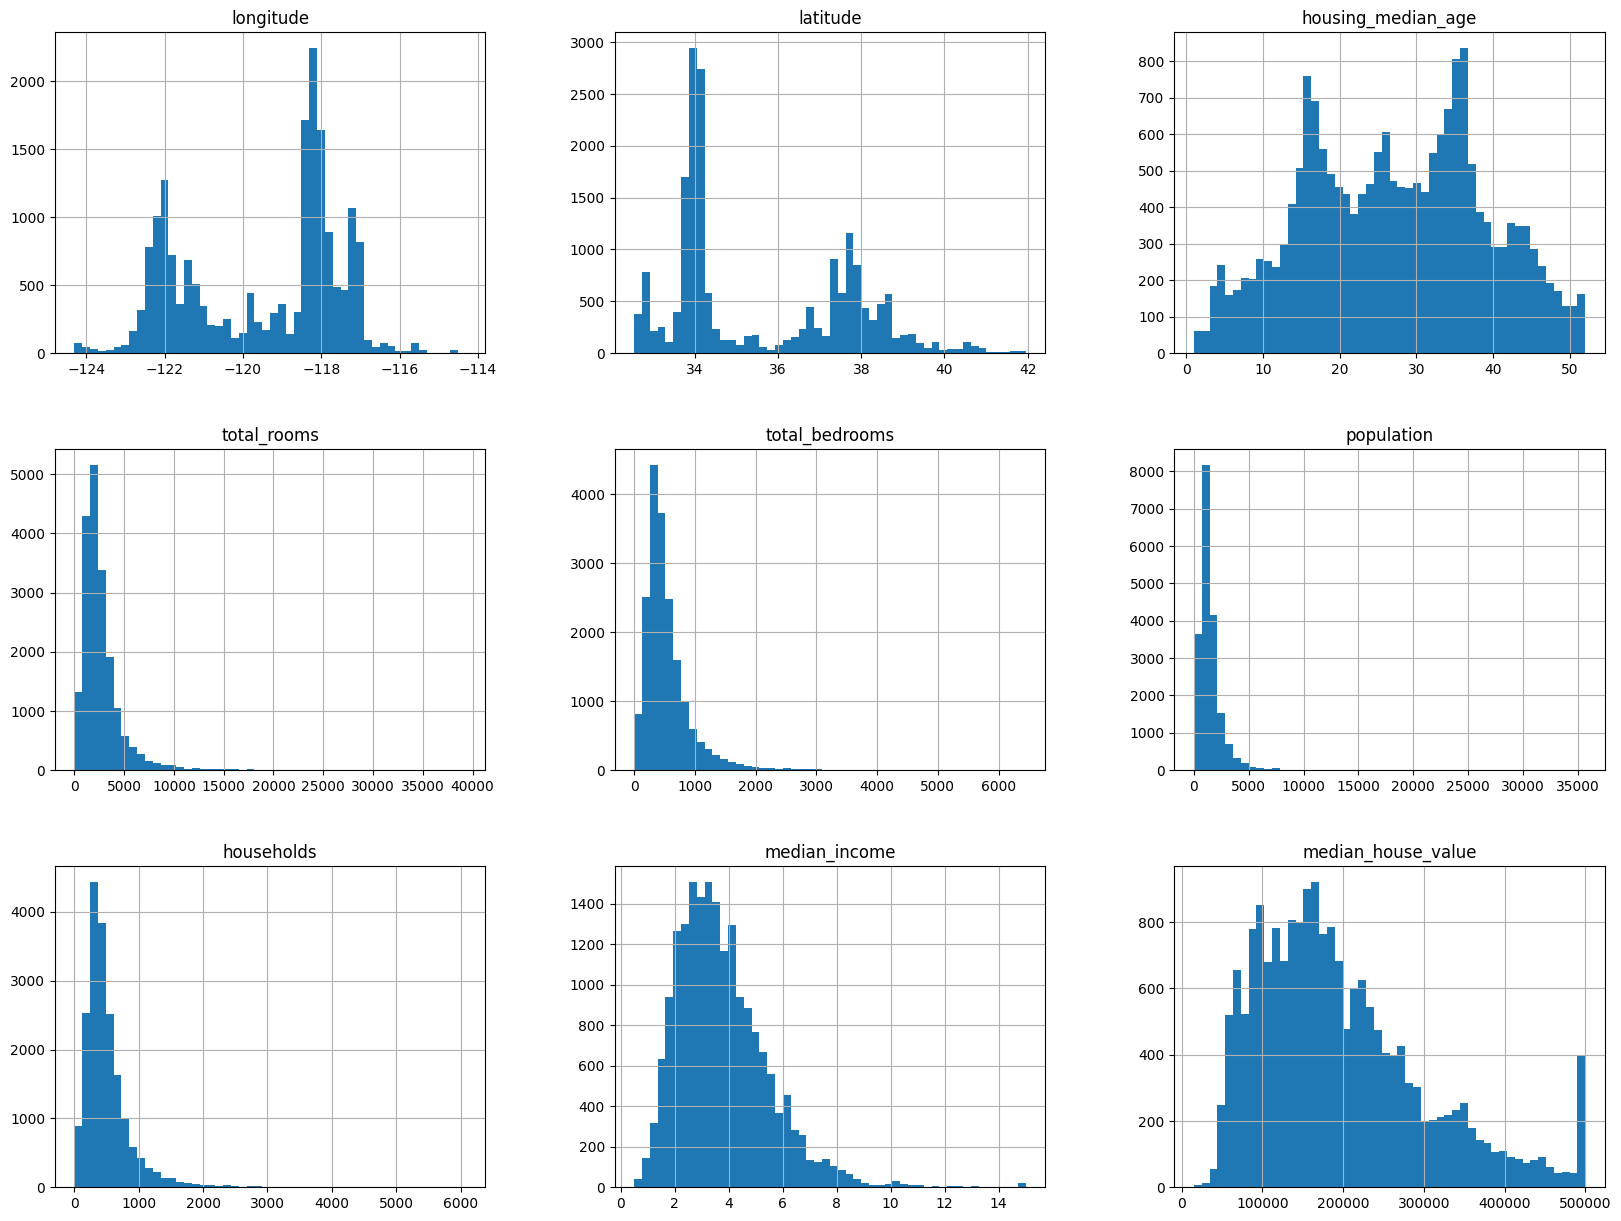

In [109]:
np.random.seed(42)
indices = source[(source['housing_median_age'] == 52)].index
drop_indices = np.random.choice(indices, round(len(indices) * 0.9), replace=False)
source1 = source.drop(drop_indices)
indices = source1[(source1['median_house_value'] > 500000)].index
drop_indices = np.random.choice(indices, round(len(indices) * 0.9))
source2 = source1.drop(drop_indices)
source2.reset_index(drop=True, inplace=True)
source2.hist(bins=50, figsize=(20,15))
plt.show()

Separando 80/20 treinamento/teste

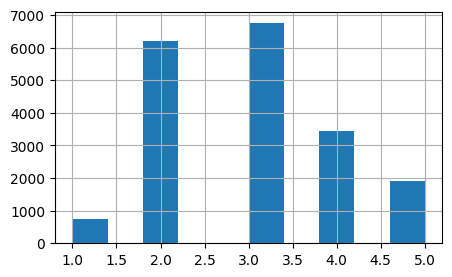

In [110]:
source2['income_cat'] = pd.cut( source2['median_income'],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])
source2['income_cat'].hist(figsize=(5, 3))
plt.show()

In [111]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(source2, source2['income_cat']):
    source_train = source2.loc[train_index]  #loc return DataFrame
    source_test = source2.loc[test_index]    #loc return DataFrame

for set_ in (source_train, source_test):
    set_.drop('income_cat', axis=1, inplace=True)

In [116]:
data = source_train.drop('median_house_value', axis=1)
data_labels = source_train['median_house_value'].copy()
data_test = source_test.drop('median_house_value', axis=1)
data_test_labels = source_test['median_house_value'].copy()
columns_num = list(data.select_dtypes(include=[np.number]))
columns_cat = list(data.select_dtypes(exclude=[np.number]))

Criando uma pipeline

In [113]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[order_ocean_proximity]))
])
pipeline = ColumnTransformer([
    ('num', num_pipeline, columns_num),
    ('cat', cat_pipeline, columns_cat)
])
#transform = pipeline.fit_transform(source2)
#source3 = pd.DataFrame(transform, columns=columns_num + columns_cat)
#source3.info()
#pipeline.named_transformers_['cat'].named_steps['OneHot_Encoder'].categories_

Treinando um modelo

In [114]:
data_prepared = pipeline.fit_transform(data)
lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_labels)
tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_prepared, data_labels)
rforest_reg = RandomForestRegressor()
rforest_reg.fit(data_prepared, data_labels)

RandomForestRegressor()

Validando os dados de treinamento

In [115]:
dados_previsoes = lin_reg.predict(data_prepared)
print('Linear', mean_squared_error(data_labels, dados_previsoes, squared=False))
dados_previsoes = tree_reg.predict(data_prepared)
print('DecisionTree', mean_squared_error(data_labels, dados_previsoes, squared=False))
dados_previsoes = rforest_reg.predict(data_prepared)
print('RandomForest', mean_squared_error(data_labels, dados_previsoes, squared=False))

Linear 63414.77477197709
DecisionTree 0.0
RandomForest 17200.45012816239


In [117]:
data_prepared = pipeline.fit_transform(data_test)
dados_previsoes = lin_reg.predict(data_prepared)
print('Linear', mean_squared_error(data_test_labels, dados_previsoes, squared=False))
dados_previsoes = tree_reg.predict(data_prepared)
print('DecisionTree', mean_squared_error(data_test_labels, dados_previsoes, squared=False))
dados_previsoes = rforest_reg.predict(data_prepared)
print('RandomForest', mean_squared_error(data_test_labels, dados_previsoes, squared=False))

Linear 63710.09260556316
DecisionTree 67294.13611723765
RandomForest 48942.77670101382
